In [ ]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

In [ ]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [ ]:
# # Data Cleaning
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})

# train['Age'] = train['Age'].fillna(round(train['Age'].mean()))
# test['Age'] = test['Age'].fillna(round(test['Age'].mean()))
# test['Fare'] = test['Fare'].fillna(round(test['Fare'].mean()))

columns_to_drop = ["PassengerId", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)


In [ ]:
class RoundingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        X = X.round() 
        return X
    
imputer = SimpleImputer(strategy='mean')
rounder = RoundingTransformer()
preprocessing_pipeline = Pipeline([
    ('imputer', imputer),
    ('rounder', rounder)
])

# Create the scaler
scaler = MinMaxScaler()

# Create the logistic regression model
lr_model = LogisticRegression(C=100, penalty='l2')

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('scaler', MinMaxScaler()),
    ('lr', lr_model)
])

In [ ]:
# Assign Features and Labels
X_train = train[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
# X_train = train[["Pclass", "Age", "Fare", "Sex_binary"]]
y_train = train["Survived"]
X_test = test[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_binary"]]
# X_test = test[["Pclass", "Age", "Fare", "Sex_binary"]]
y_test = gender_submission["Survived"]

In [ ]:
# # Fit the pipeline to your training data 
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

In [ ]:

accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
import matplotlib.pyplot as plt

# Cross-Validation Curve
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(cv_scores)  # Example output

# Learning Curve 
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=10)
plt.plot(train_sizes, train_scores, label='Training')
plt.plot(train_sizes, test_scores, label='Testing')
plt.legend()
plt.show()


In [ ]:
# Hyperparameter Grid (adjust as needed)
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 110, 125, 150, 200],
    'lr__C': np.logspace(-3, 2, num=10),
    'lr__solver': ['liblinear', 'saga'],
    'lr__class_weight': [None, 'balanced']
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10)
grid_search.fit(X_train, y_train)
# print(grid_search.best_params_) 

best_model = grid_search.best_estimator_
# best_model.steps[-1][1].solver = 'liblinear'  # Or 'saga' 
best_model.steps[-1][1].solver = 'saga'  # Or 'liblinear' 

# RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=20) 
random_search.fit(X_train, y_train)
# print(random_search.best_params_)

# BayesSearchCV
bayes_search = BayesSearchCV(pipeline, param_grid, cv=5) 
bayes_search.fit(X_train, y_train) 
# print(bayes_search.best_params_) 


In [ ]:
print(f"grid_search.best_params_: {grid_search.best_params_}") 
print(f"random_search.best_params_: {random_search.best_params_}")
print(f"bayes_search.best_params_: {bayes_search.best_params_}") 

print(f"Grid Search best score: {grid_search.best_score_}")
print(f"Random Search best score: {random_search.best_score_}")
print(f"Bayes Search best score: {bayes_search.best_score_}")

best_params = {'C': 0.5994842503189409, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# model = LogisticRegression(**best_params) 
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('scaler', MinMaxScaler()),
    ('lr', LogisticRegression(**best_params) )
])

# # Fit the pipeline to your training data 
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Pipeline model accuracy: {accuracy}")

In [ ]:
# from hyperopt import fmin, tpe, hp

# # Define the objective function (example)
# def objective(params):
#     pipeline.set_params(**params)  
#     return -np.mean(cross_val_score(pipeline, X_train, y_train, cv=5)) 

# # Define the search space 
# space = {
#     'lr__penalty': hp.choice('lr__penalty', ['l2']),
#     'lr__C': hp.uniform('lr__C', 0.001, 10)
# }

# # Run TPE optimization
# best = fmin(objective, space, algo=tpe.suggest, max_evals=50) 


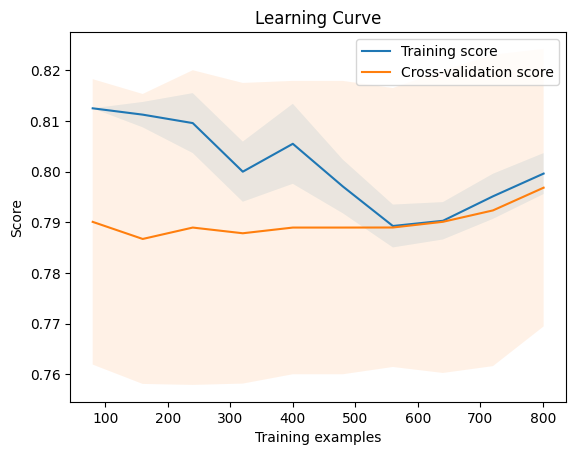

In [263]:
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate means and standard deviations for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()


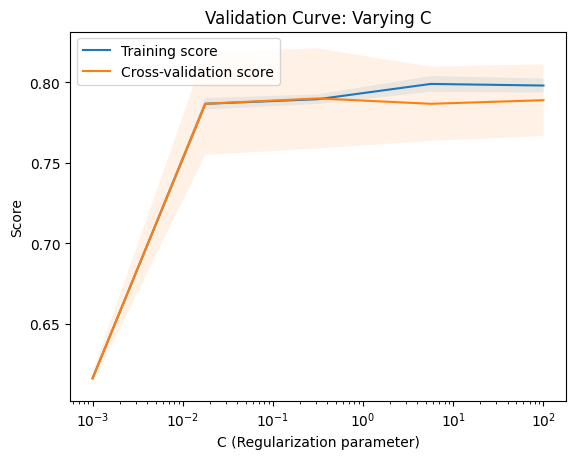

In [265]:
param_name = 'lr__C'  # Choose a hyperparameter to vary
param_range = np.logspace(-3, 2, num=5)

train_scores, test_scores = validation_curve(
    pipeline, X_train, y_train, param_name=param_name, param_range=param_range, cv=10)

# Calculate means and standard deviations 
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label='Training score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(param_range, test_mean, label='Cross-validation score')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Validation Curve: Varying C")
plt.xlabel("C (Regularization parameter)")
plt.ylabel("Score")
plt.legend()
plt.xscale('log') 
plt.show()
